# 5章 誤差逆伝播法
---

## 5.1 計算グラフ

視覚的に順伝播・逆伝播を理解する方法

## 5.2 連鎖律

連鎖律とは以下のような合成関数の微分についての性質を示す

> ある関数が合成関数で表される場合、その合成関数の微分は、合成関数を構成するそれぞれの関数の微分の積によって表すことができる。
>
> <div style="text-align: right;"><cite>"ゼロから作るDeep Learning", p. 130</cite></div>

## 5.3 逆伝播

* 加算ノードの逆伝播では右側からの信号をそのまま左のノードへ出力する
* 乗算ノードの逆伝播では右側からの信号に順伝播の際の入力信号をひっくり返した値を乗算して左のノードへ出力する

## 5.4 単純なレイヤの実装

### 5.4.1 乗算レイヤの実装

In [1]:
#######################
# ch05/layer_naive.py #
#######################

class MulLayer:
    
    def __init__(self):
        self.x = None
        self.y = None
    
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy


In [2]:
#####################
# ch05/buy_apple.py #
#####################

apple = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print('price: ' + str(price))

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print('dapple: ' + str(dapple))
print('dapple_num: ' + str(dapple_num))
print('dtax: ' + str(dtax))

price: 220.00000000000003
dapple: 2.2
dapple_num: 110.00000000000001
dtax: 200


In [3]:
#######################
# ch05/layer_naive.py #
#######################

class AddLayer:
    
    def __init__(self):
        pass
    
    
    def forward(self, x, y):
        out = x + y
        return out
    
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy


In [4]:
############################
# ch05/buy_apple_orange.py #
############################

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print('price: ' + str(price))
print('dapple_num: ' + str(dapple_num))
print('dapple: ' + str(dapple))
print('dorange: ' + str(dorange))
print('dorange_num: ' + str(dorange_num))
print('dtax: ' + str(dtax))

price: 715.0000000000001
dapple_num: 110.00000000000001
dapple: 2.2
dorange: 3.3000000000000003
dorange_num: 165.0
dtax: 650


## 5.5 活性化関数レイヤの実装

### 5.5.1 ReLUレイヤ

In [5]:
###################
# common/layer.py #
###################

class Relu:
    
    def __init__(self):
        self.mask = None
    
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dout


### 5.5.2 Sigmoidレイヤ

In [6]:
###################
# common/layer.py #
###################

class Sigmoid:
    
    def __init__(self):
        self.out = None
    
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


## 5.6 Affine / Softmaxレイヤの実装

### 5.6.1 Affineレイヤ

In [7]:
class Affine:
    
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    
    def forward(self, x):
        self.x = x
        out = np.dout(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx


### 5.6.3 Softmax-with-Lossレイヤ

In [8]:
###################
# common/layer.py #
###################

import sys, os
sys.path.append(os.pardir)
from common.functions import cross_entropy_error, softmax


class SoftmaxWithLoss:
    
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx


## 5.7 誤差逆伝播法の実装

### 5.7.1 ニューラルネットワークの学習の全体図
1. ミニバッチの作成
2. 勾配の算出
3. パラメータの更新
4. 繰り返し

In [9]:
#########################
# ch05/two_layer_net.py #
#########################

import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
    
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 :
            t = np.argmax(t, axis=1)        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads


## 5.7.3 誤差逆伝播法の勾配確認

### 数値微分と誤差逆伝播法の特徴

* 数値微分: 計算に時間がかかるが、実装が簡単
* 誤差逆伝播法: 計算が速いが、実装が複雑でミスが起きやすい

数値微分で求めた勾配と、誤差逆伝播法で求めた勾配の結果が一致することを確認する作業を**勾配確認**と言う

In [10]:
##########################
# ch05/gradient_check.py #
##########################

import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist


# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))


Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
W1:2.3545864239e-13
b1:8.29204726801e-13
W2:8.80419047911e-13
b2:1.20348178645e-10


## 5.7.4 誤差逆伝播法を使った学習

In [11]:
###########################
# ch05/train_neuralnet.py #
###########################

import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist


# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


0.147966666667 0.1492
0.905016666667 0.9104
0.9244 0.925
0.937683333333 0.9388
0.945833333333 0.9452
0.952 0.9506
0.955833333333 0.9545
0.960816666667 0.9568
0.964216666667 0.9592
0.966233333333 0.9626
0.969016666667 0.9639
0.970933333333 0.9657
0.97415 0.9674
0.975483333333 0.9699
0.977083333333 0.9701
0.978266666667 0.9701
0.97955 0.9716


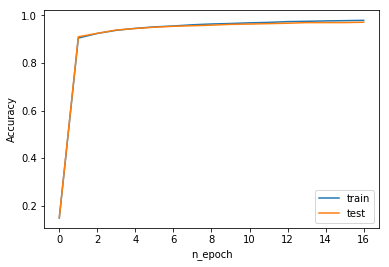

In [12]:
import matplotlib.pyplot as plt

epoch_list = range(len(test_acc_list))
plt.plot(epoch_list, train_acc_list, label="train")
plt.plot(epoch_list, test_acc_list, label="test")
plt.xlabel('n_epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# References
---

* [誤差逆伝播法のノート](http://qiita.com/Ugo-Nama/items/04814a13c9ea84978a4c)